In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

In [3]:
import sys
!pip install tensorflow-addons

In [4]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import GAN
from backend.tcn import make_TCN

In [5]:
from scipy.stats import norm, pearsonr

[*********************100%***********************]  1 of 1 completed


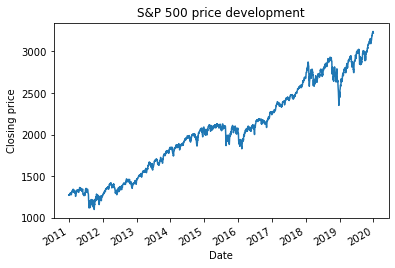

In [6]:
data = yf.download("^GSPC", start="2011-01-01", end="2019-12-31")
df = data['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig, ax = plt.subplots()
df.plot(ylabel='Closing price', title='S&P 500 price development');

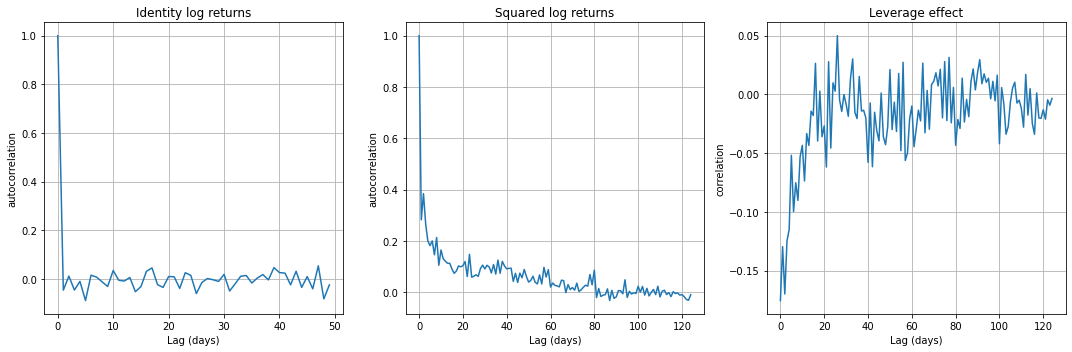

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 125))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 125, le=True))
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='Lag (days)')
plt.setp(axs[0:2], ylabel='autocorrelation')
axs[2].set_ylabel('correlation')
plt.tight_layout();

In [8]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

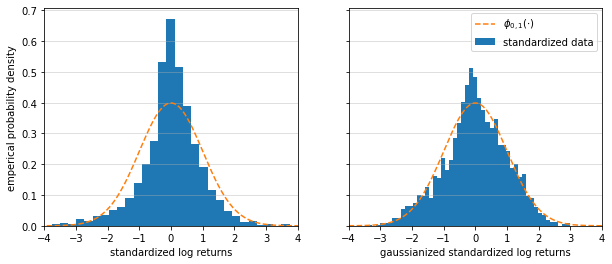

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, sharex=True)
# We plot the distribution of log returns before and after the
# lambert W inverse transform respectively (both standardized). 
# We overlay it with a standard normal.

ax[0].hist(s1.transform(log_returns), bins=50, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=50, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['$\phi_{0, 1}(\cdot)$', 'standardized data'])
ax[0].set_ylabel('emperical probability density')
ax[0].set_xlabel('standardized log returns')
ax[1].set_xlabel('gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

plt.savefig('gaussianize.png', dpi=300);
#files.download("gaussianize.png") 

In [10]:
dilations = 2**(np.arange(6))
n_filters = 100

discriminator = make_TCN(dilations, n_filters, 0, False, False, False, [1, rfs, 1])
generator = make_TCN(dilations, n_filters, 0, True, False, False, [1, None, 3])

In [11]:
from tensorflow.random import normal

In [12]:
class verboseGAN(GAN):
    # override the train hook method to print some metrics during training
    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
gan = verboseGAN(discriminator, generator, 2*rfs - 1, lr_d=1e-4, lr_g=3e-5)

gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

# noise that stays constant for displaying metrics
gan.fixed_noise = normal([128, 1, 4000 + rfs - 1, 3])

In [13]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
batch_size = 64
n_batches = 3000
additional_d_steps = 0

# It may appear that I'm stopping while acf_abs is still significantly decreasing,
# but it has the tendency to increase after ~3000 steps.
gan.train(data, batch_size, n_batches, additional_d_steps)

 499/3000 [===>..........................] - ETA: 1:47:45
acf: 0.3629, acf_abs: 1.0024, le: 0.3879
 999/3000 [========>.....................] - ETA: 1:27:10
acf: 0.3640, acf_abs: 0.7194, le: 0.3828
1499/3000 [=============>................] - ETA: 1:07:09
acf: 0.3534, acf_abs: 0.5015, le: 0.3671
1999/3000 [==================>...........] - ETA: 44:31
acf: 0.3460, acf_abs: 0.5448, le: 0.3411
2499/3000 [=======================>......] - ETA: 22:10
acf: 0.3368, acf_abs: 0.5063, le: 0.3574
2999/3000 [============================>.] - ETA: 3s
acf: 0.3359, acf_abs: 0.4802, le: 0.3734
3000/3000 [==============================] - 9610s 3s/step


In [14]:
noise = normal([128, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
# unfortunately guassianize package doesnt support efficient column-wise transform
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

#We retain a majority of samples
len(y)

104

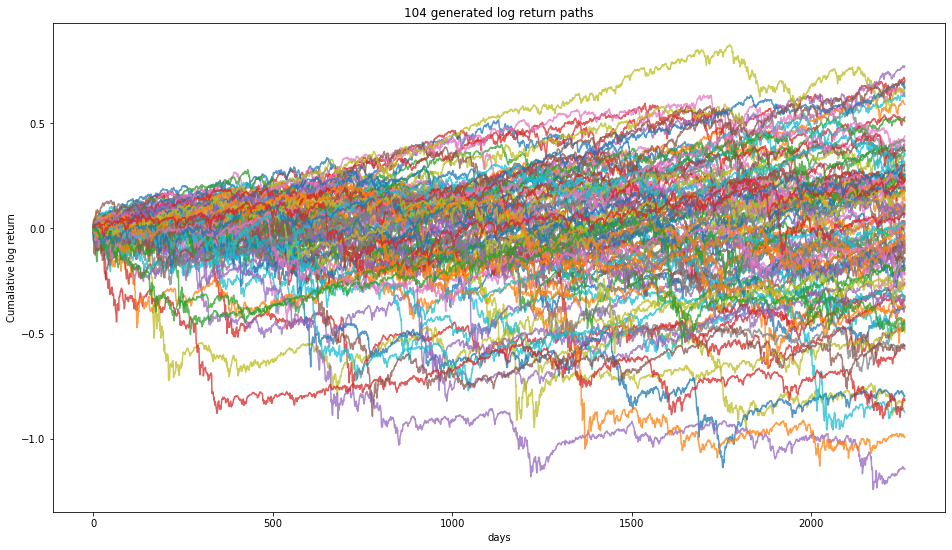

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y, axis=1).T, alpha=0.75)
ax.set_title('{} generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

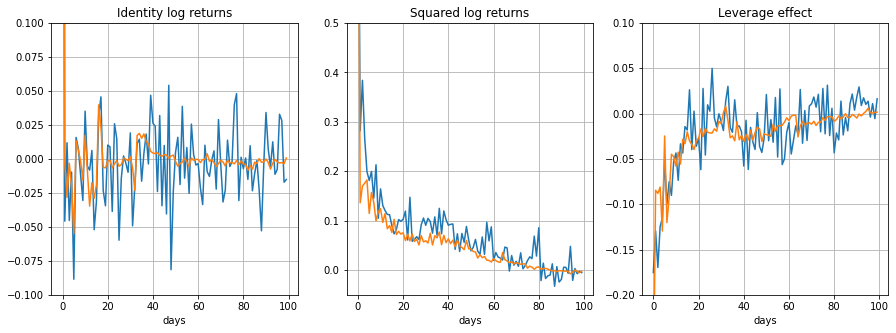

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 100, le=True))
axs[2].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');